#  MERA

## 概述

在本教程中，我们将不涉及物理层面的探讨，而将演示如何使用TyxonQ实现MERA (多尺度纠缠重整化假设，multi-scale entangled renormalization ansatz)。

## 背景

MERA是VQE的其中一种。它由一个量子比特的 $\ket{0}$ 态开始，逐层添加新的量子比特以扩张希尔伯特空间。
在将要训练的MERA（记作 $U(\theta)$ ）中，我们使用可变参量子门 $e^{i\theta XX}$ 、$e^{i\theta ZZ}$ 作为双比特门，以及 $e^{i\theta X}$ 、$e^{i\theta Z}$ 作为单比特门。
在本教程中，我们使用的哈密顿量是横场伊辛模型的哈密顿量 $\hat{H}_{Ising}=J\sum_{i}{Z_{i}Z_{i+1}}-B_{x}\sum_{i}{X_{i}}$。
我们要减小的损失函数是 $\mathcal{L}_{MERA}(\rm{\theta})=\langle 0^n\vert U(\theta)^\dagger \hat{H} U(\theta)\vert 0^n\rangle$。

## 设置

In [ ]:
import numpy as np
import torch
import tyxonq as tq

tq.set_backend("pytorch")
tq.set_dtype("complex128")

('complex128', 'float64')

## 能量
我们先设计哈密顿量的能量期望函数作为损失函数。
$$ \hat{H}_{Ising}=J\sum_{i}{Z_{i}Z_{i+1}}-B_{x}\sum_{i}{X_{i}} $$

In [ ]:
def energy(c: tq.Circuit, j: float = 1.0, hx: float = 1.0):
    e = 0.0
    n = c._nqubits
    # <Z_i Z_{i+1}>
    for i in range(n - 1):
        e += j * c.expectation((tq.gates.z(), [i]), (tq.gates.z(), [i + 1]))
    # <X_i>
    for i in range(n):
        e -= hx * c.expectation((tq.gates.x(), [i]))
    return tq.backend.real(e)

## MERA 电路

现在，我们设计电路。我们用 $\theta$ 作为输入。

In [ ]:
def MERA(params, n):
    params = tq.backend.cast(params, "complex128")
    c = tq.Circuit(n)

    idx = 0  # index of params

    for i in range(n):
        c.rx(i, theta=params[2 * i])
        c.rz(i, theta=params[2 * i + 1])
    idx += 2 * n

    for n_layer in range(1, int(np.log2(n)) + 1):
        n_qubit = 2**n_layer  # number of qubits involving
        step = int(n / n_qubit)

        # 偶数层
        for i in range(step, n - step, 2 * step):
            c.exp1(i, i + step, theta=params[idx], unitary=tq.gates._xx_matrix)
            c.exp1(i, i + step, theta=params[idx + 1], unitary=tq.gates._zz_matrix)
            idx += 2

        # 奇数层
        for i in range(0, n, 2 * step):
            c.exp1(i, i + step, theta=params[idx], unitary=tq.gates._xx_matrix)
            c.exp1(i, i + step, theta=params[idx + 1], unitary=tq.gates._zz_matrix)
            idx += 2

        # 单比特门
        for i in range(0, n, step):
            c.rx(i, theta=params[idx])
            c.rz(i, theta=params[idx + 1])
            idx += 2

    # 测量
    e = energy(c)
    return e
    # return c, idx

我们可以将MERA电路可视化。 

注意：请把return改为`return c, idx`。这个return只有在这儿会被用到。可视化完成后，请别忘了将return还原并重新运行上方代码块。

The number of parameters is 66


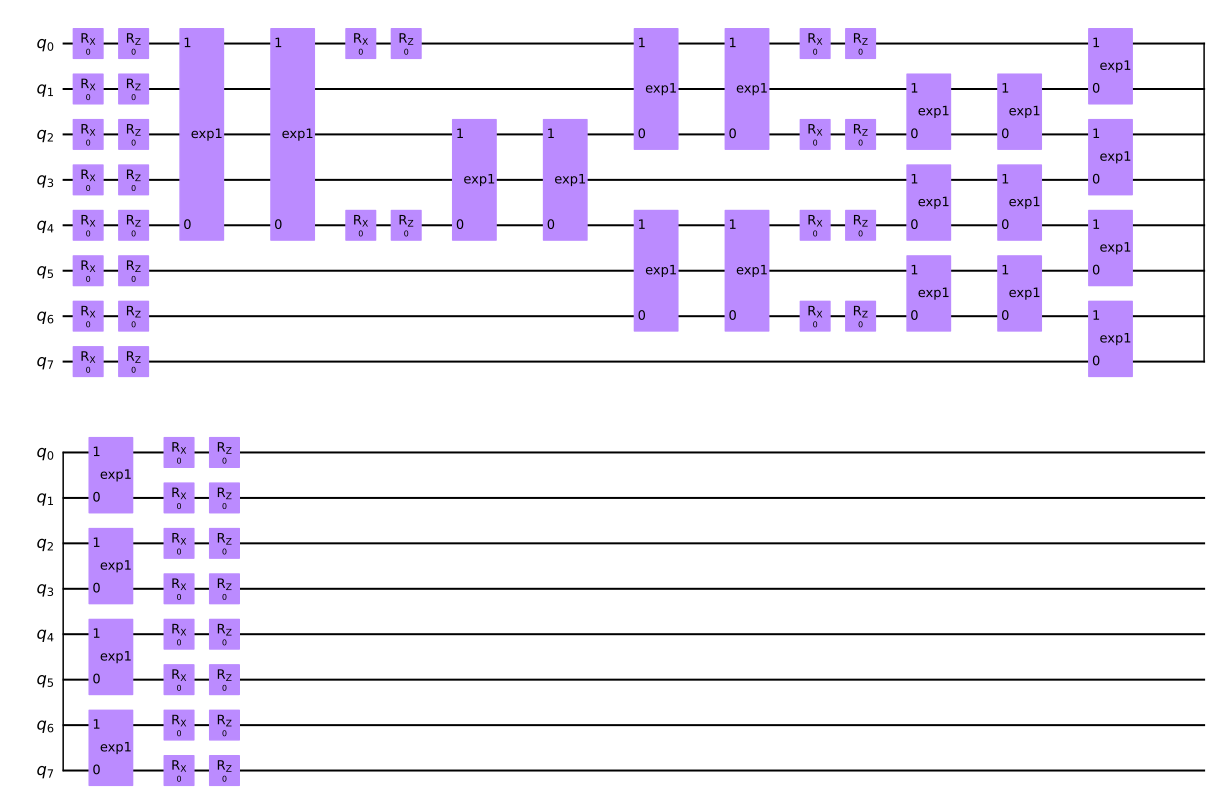

In [ ]:
n = 8
cirq, idx = MERA(np.zeros(1000), n)
print("The number of parameters is", idx)
# warning pytorch might be unable to do this
# cirq.draw() # pytorch might not have the draw functionality

## 训练

现在，我们使用TyxonQ训练MERA电路。

In [ ]:
MERA_tfim_vvag = tq.backend.jit(tq.backend.vectorized_value_and_grad(MERA))


def batched_train(n, batch=10, maxiter=10000, lr=0.005):
    params = torch.tensor(
        torch.randn(size=[batch, idx], dtype=tq.rdtype),
        requires_grad=True
    )
    opt = torch.optim.Adam([params], lr=lr)
    lowest_energy = 1e5
    for i in range(maxiter):
        e, grad = MERA_tfim_vvag(params, n)
        params.grad = grad
        opt.step()
        opt.zero_grad()
        if torch.min(e) < lowest_energy:
            lowest_energy = torch.min(e).item()
        if i % 200 == 0:
            print(e)
    return lowest_energy


n = 8
lowest_energy = batched_train(n, batch=5, maxiter=2000, lr=0.007)

tf.Tensor([-0.6449017   0.14083987  0.17227418  1.42731099  0.93767164], shape=(5,), dtype=float64)
tf.Tensor([-9.57952648 -9.15354269 -9.53415983 -9.55291257 -9.46880555], shape=(5,), dtype=float64)
tf.Tensor([-9.63166728 -9.60922826 -9.59883555 -9.66639936 -9.60174669], shape=(5,), dtype=float64)
tf.Tensor([-9.65441326 -9.61830383 -9.6219077  -9.68289435 -9.61427165], shape=(5,), dtype=float64)
tf.Tensor([-9.66991104 -9.6307931  -9.64993901 -9.71396225 -9.63848947], shape=(5,), dtype=float64)
tf.Tensor([-9.67960751 -9.64303661 -9.67696885 -9.76317346 -9.6507455 ], shape=(5,), dtype=float64)
tf.Tensor([-9.68303361 -9.6575349  -9.70118521 -9.7740601  -9.65751254], shape=(5,), dtype=float64)
tf.Tensor([-9.68481667 -9.67473162 -9.71392119 -9.78200161 -9.66880068], shape=(5,), dtype=float64)
tf.Tensor([-9.6864865  -9.67835678 -9.73033137 -9.79128949 -9.68317883], shape=(5,), dtype=float64)
tf.Tensor([-9.68762425 -9.67928153 -9.77502182 -9.79465957 -9.69252806], shape=(5,), dtype=float64)


## 对比

我们可以把我们用MERA得到的基态能量和DMRG进行对比。

In [ ]:
# DMRG
import quimb

h = quimb.tensor.tensor_gen.MPO_ham_ising(n, j=4.0, bx=2.0, S=0.5, cyclic=False)
dmrg = quimb.tensor.tensor_dmrg.DMRG(
    h, bond_dims=[10, 20, 100, 100, 200], cutoffs=1e-13
)
dmrg.solve(tol=1e-9, verbosity=0)
energy_DMRG = dmrg.energy

# Compare
print("DMRG solution: ", energy_DMRG)
print("MERA solution: ", lowest_energy)

DMRG solution:  -9.837951447459426
MERA solution:  -9.795198473308487
